# Imports

In [13]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import math 
import pylab 

from matplotlib.dates import DateFormatter
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error
from glob import glob
from os import path
from collections import defaultdict
from virocon import (
    GlobalHierarchicalModel,
    ExponentiatedWeibullDistribution,
    WeibullDistribution,
    DependenceFunction,
    WidthOfIntervalSlicer,
    plot_marginal_quantiles,
    plot_dependence_functions,
    _fitting
)

from virocon._fitting import (
    fit_function,
    fit_constrained_function,
    convert_bounds_for_curve_fit,
)

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

%matplotlib notebook

# Data

In [14]:
# Read data

data = pd.read_csv('/Volumes/MASTERTHESE/MasterThese/data_unsorted.csv')
data= data.drop(columns=['Unnamed: 0'])
data= data.rename(columns={"peakDeflection": "peakDeflectionSBIT"})

In [15]:
#print(len(data))
#print(data)

In [16]:
#plt.figure(figsize=(10,7))
#plt.plot(data.windSpeed, label='wind speed')
#plt.plot(data.waveHeight, label='wave height')
#plt.plot(data.waveTp, label='wave peak period')
#plt.plot(data.waveTz, label='Wave zero up-crossing period')
#plt.legend()

<IPython.core.display.Javascript object>


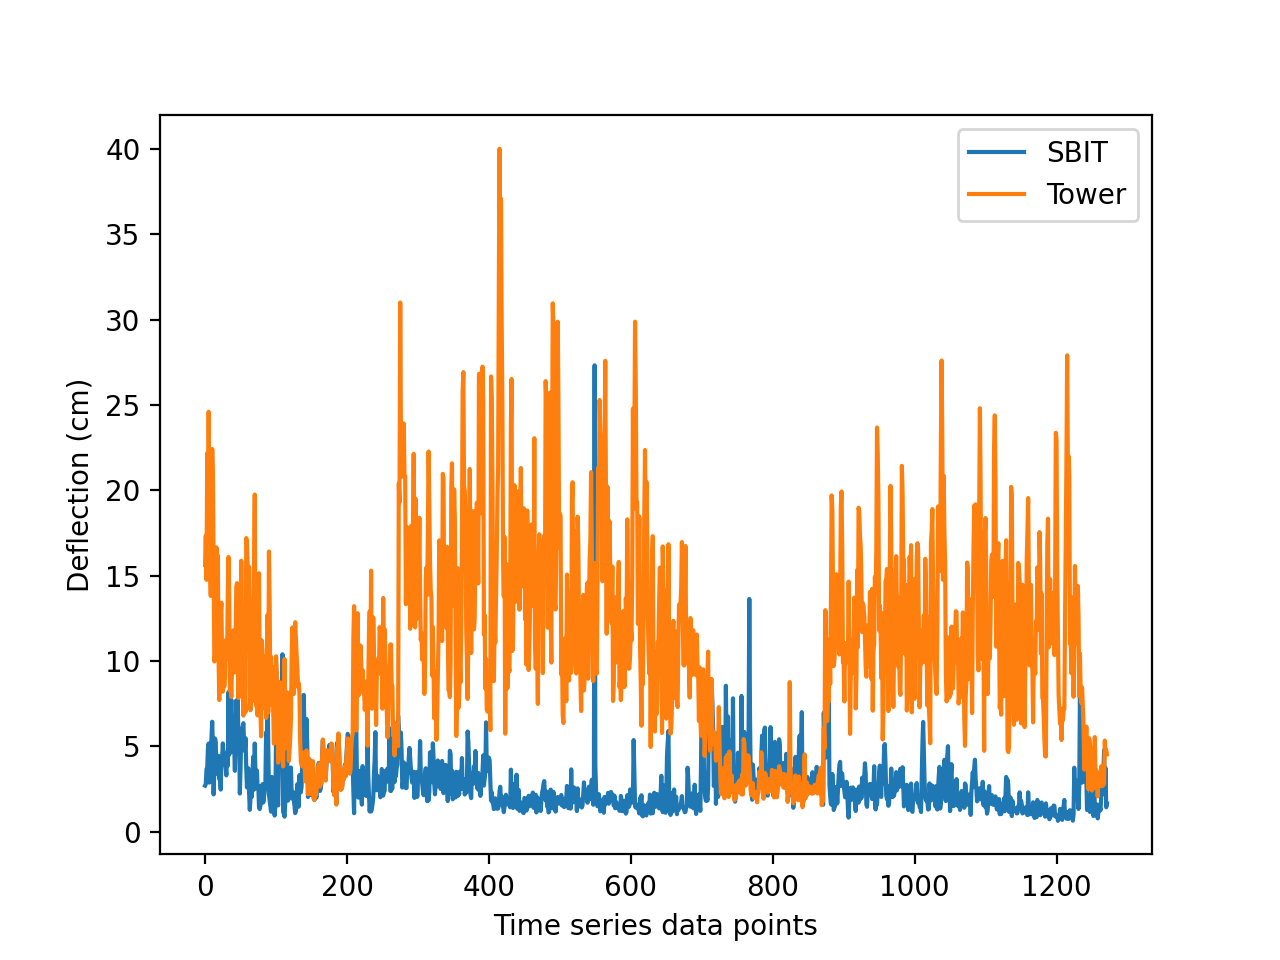

In [17]:
plt.figure()
plt.plot(data.peakDeflectionSBIT, label='SBIT')
plt.plot(data.peakDeflectionTower, label='Tower')
plt.xlabel('Time series data points')
plt.ylabel('Deflection (cm)')
plt.legend()

In [18]:
data = data.drop(data[(data.peakDeflectionTower- data.peakDeflectionSBIT) < 5].index)
data = data[data['windSpeed'].notna()]
data= data.reset_index(drop=True)
print(data)

     windSpeed  waveHeight  waveTp  waveTz  peakDeflectionSBIT  \
0     4.064444        1.39    7.14   5.263              2.7032   
1     3.959574        1.39    7.14   5.263              2.7870   
2     3.863043        1.39    7.14   5.263              3.6654   
3     3.744186        1.39    7.14   5.263              3.7484   
4     3.872340        1.39    7.14   5.263              4.8689   
..         ...         ...     ...     ...                 ...   
795   3.237931        0.54    4.35   3.361              2.8250   
796   3.827119        0.54    4.35   3.361              2.9406   
797   3.351724        0.54    4.35   3.361              1.3385   
798   3.532203        0.54    4.35   3.361              2.5891   
799   4.589655        0.54    4.35   3.361              2.8813   

     peakDeflectionTower  
0                15.6301  
1                17.3423  
2                14.7588  
3                22.1884  
4                15.9363  
..                   ...  
795              1

In [19]:
print(max(data.windSpeed))

11.192982456140356


<IPython.core.display.Javascript object>


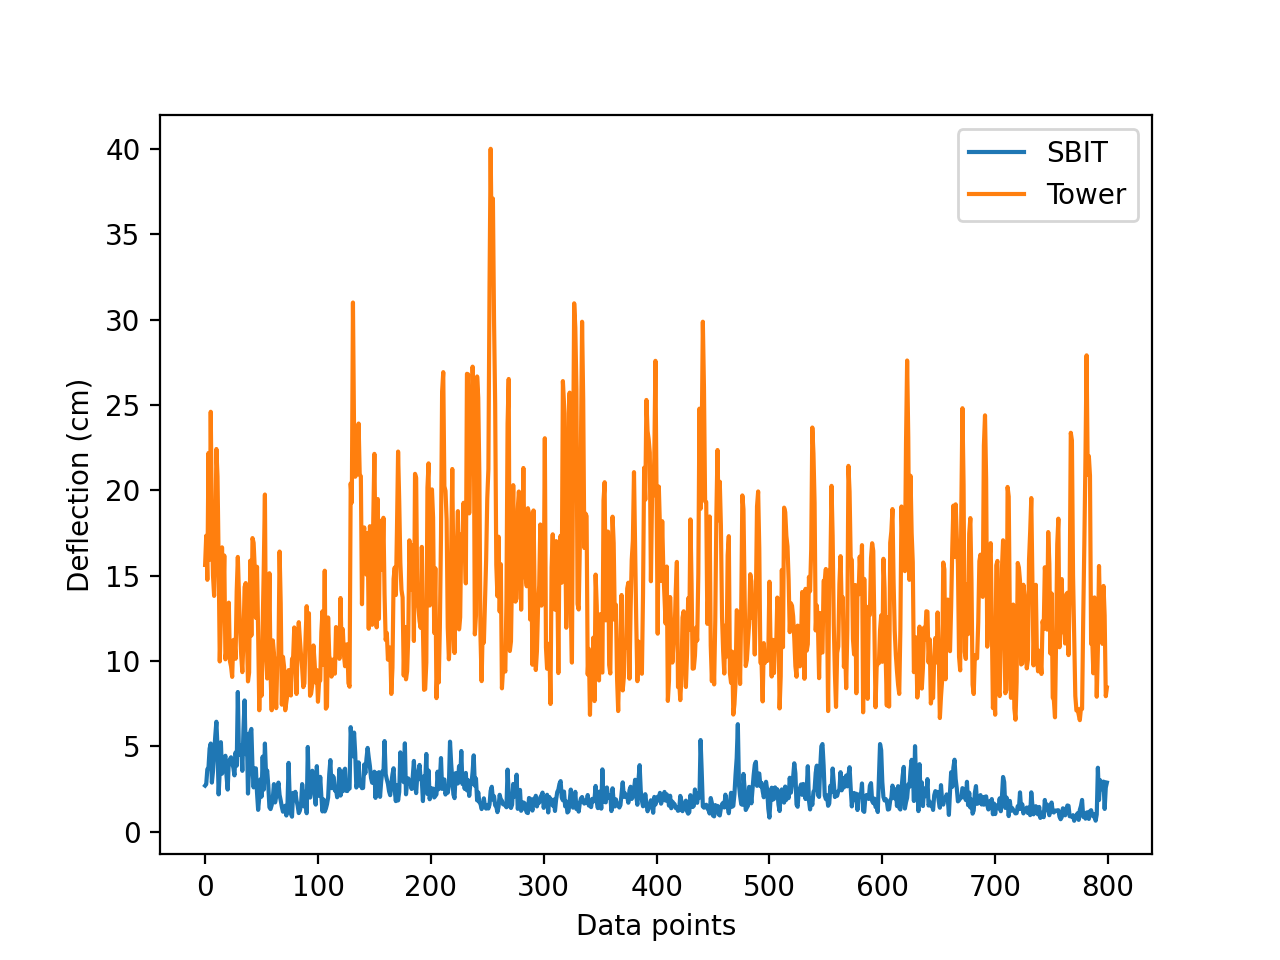

In [20]:
plt.figure()
plt.plot(data.peakDeflectionSBIT, label='SBIT')
plt.plot(data.peakDeflectionTower, label='Tower')
plt.xlabel('Data points')
plt.ylabel('Deflection (cm)')
plt.legend()

<IPython.core.display.Javascript object>


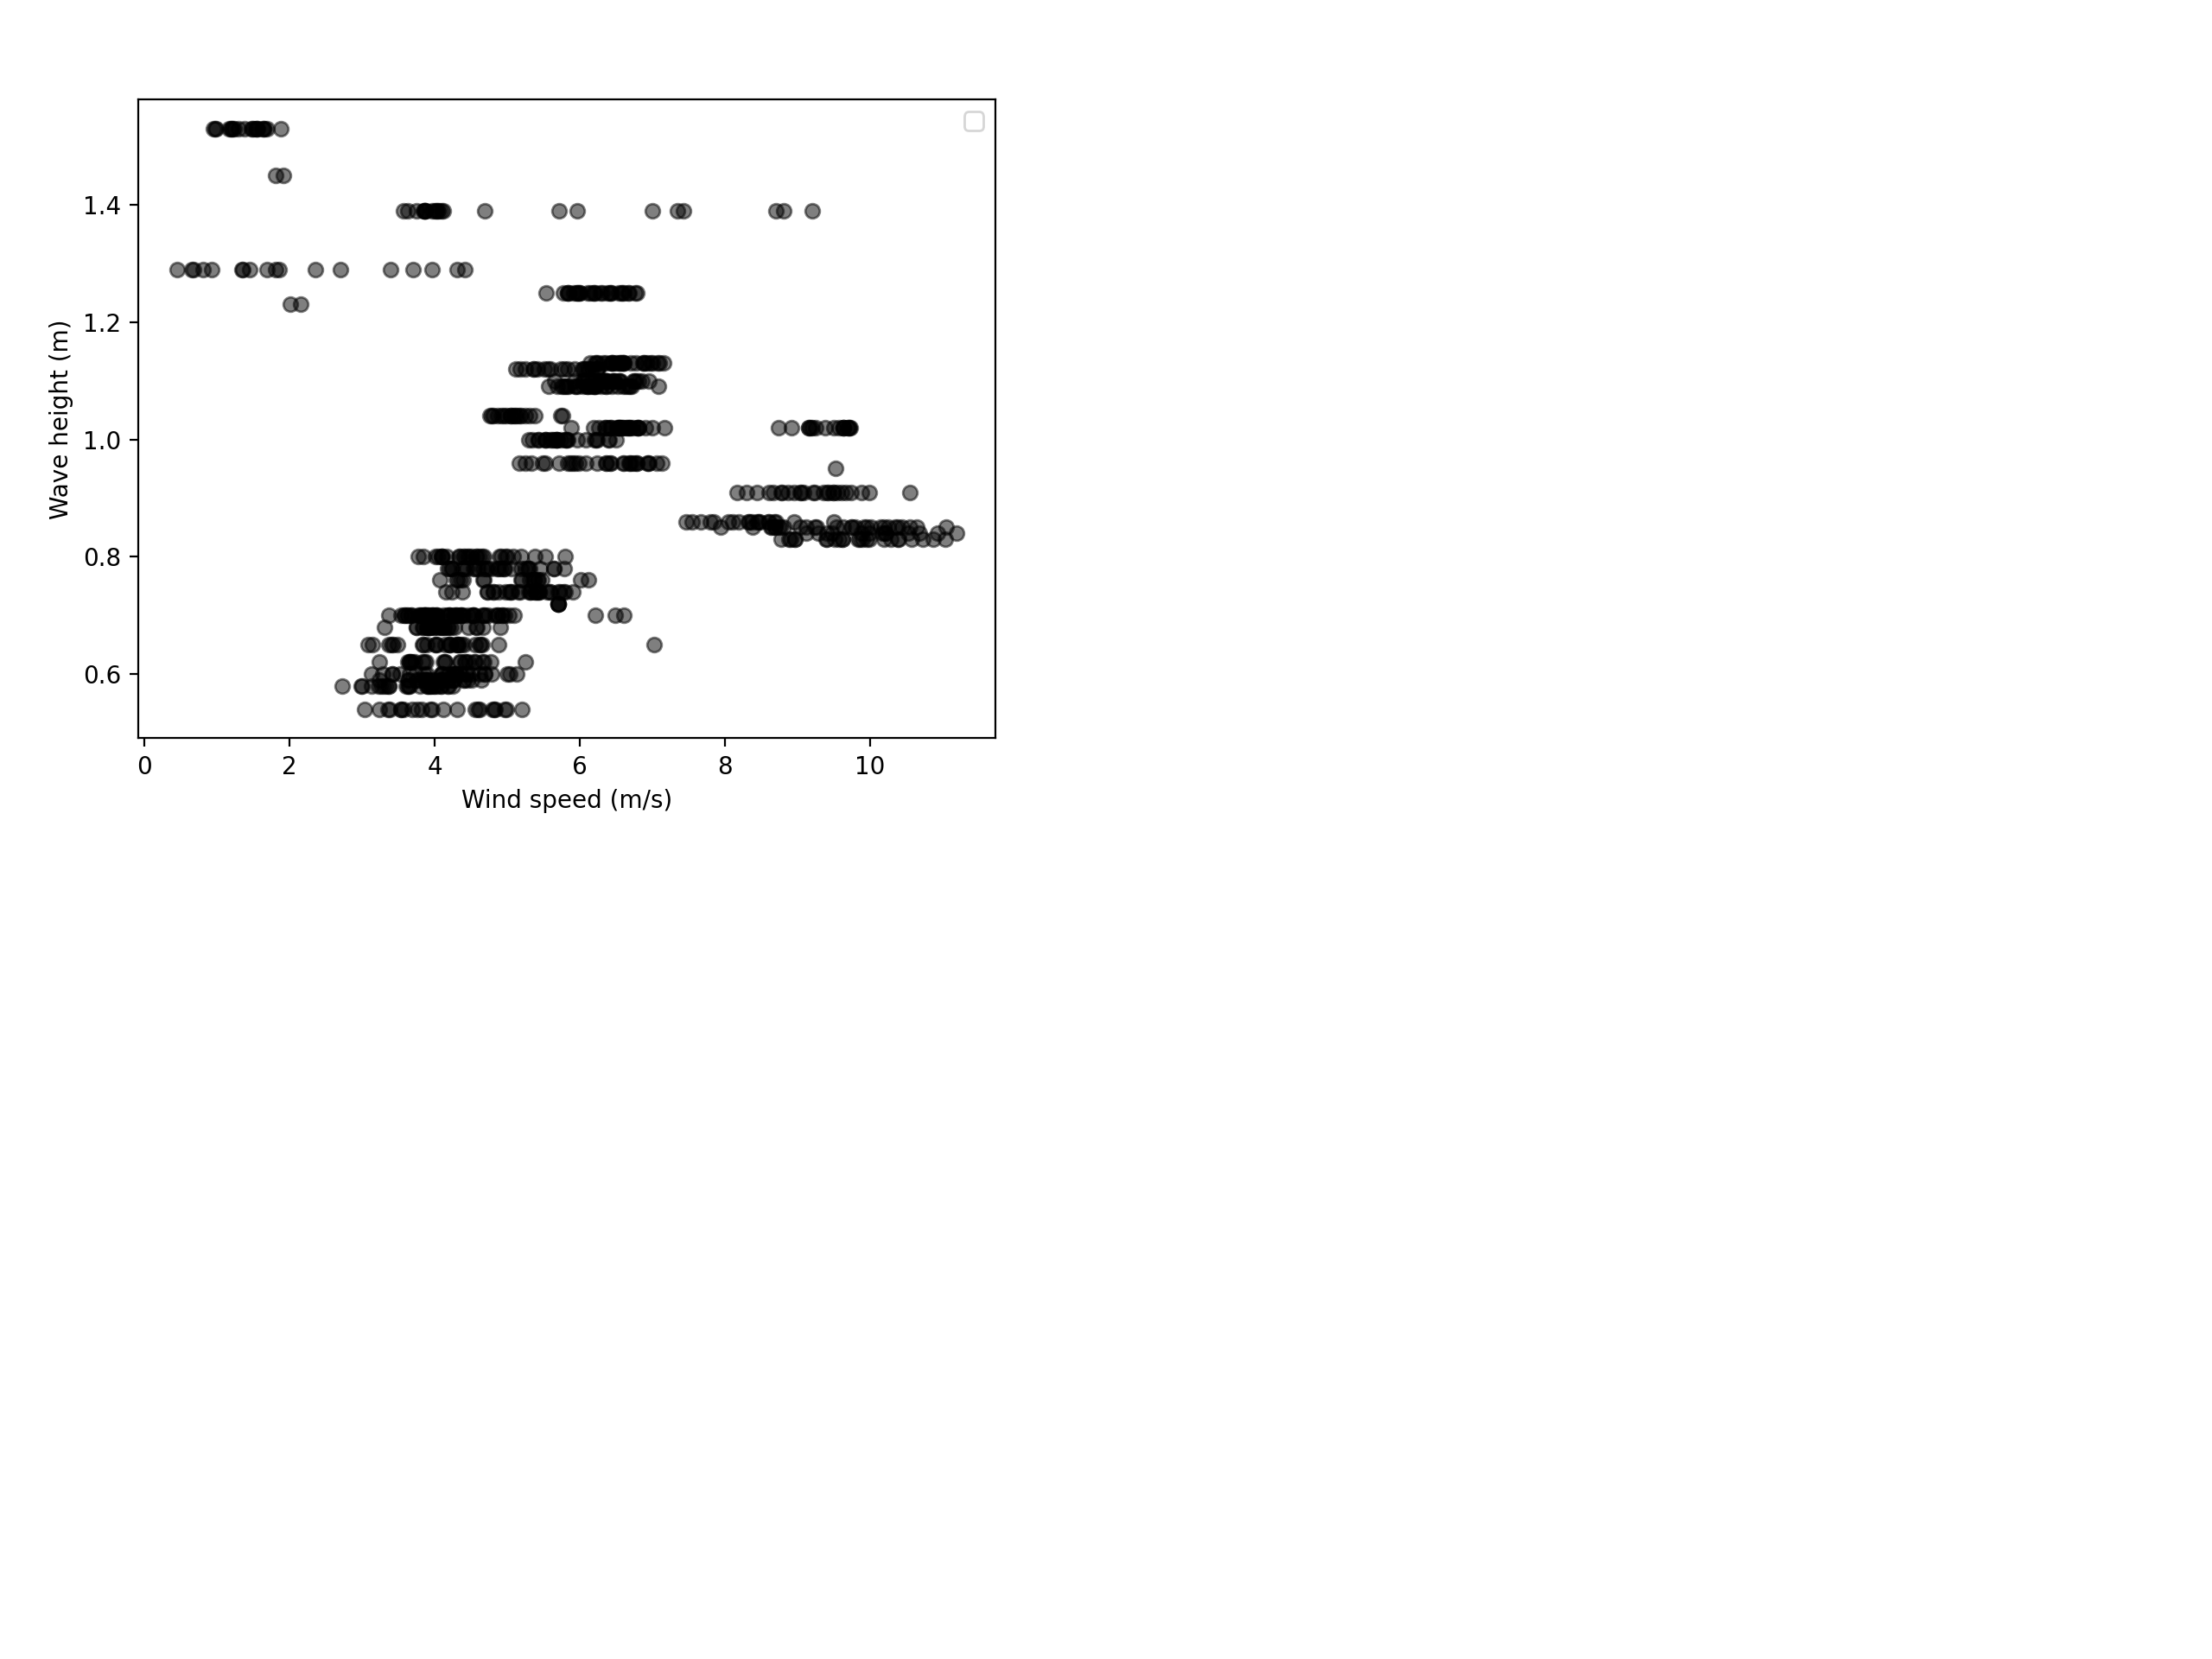

No handles with labels found to put in legend.


In [69]:
plt.figure()
plt.scatter(data.windSpeed,data.waveHeight, alpha=0.5, color='k')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Wave height (m)')
plt.legend()

# SBIT RESPONSE EMULATOR

# Distributions

In [22]:
# set up the histogramm, 60 steps= bin size of 0,5 cm deflection
bins = np.linspace(0, 30, 60)
bin_centers = 0.5*(bins[1:] + bins[:-1])

# fit GEV and weibull distribution to data
gev_fit = stats.genextreme.fit(data.peakDeflectionSBIT)
gev_pdf= stats.genextreme.pdf(bin_centers, gev_fit[0], loc= gev_fit[1], scale= gev_fit[2])
gev_ppf= stats.genextreme.ppf(bin_centers, gev_fit[0], loc= gev_fit[1], scale= gev_fit[2])
gev_cdf= stats.genextreme.cdf(bin_centers, gev_fit[0], loc= gev_fit[1], scale= gev_fit[2])

#weib_fit = stats.weibull_min.fit(data.deflection)
#weib_cdf= stats.weibull_min.cdf(bin_centers, weib_fit[0], loc= weib_fit[1], scale= weib_fit[2])

#print(weib_fit)
print(gev_fit)

(-0.1280961498390108, 1.7931853339550328, 0.7194948859860504)


<IPython.core.display.Javascript object>


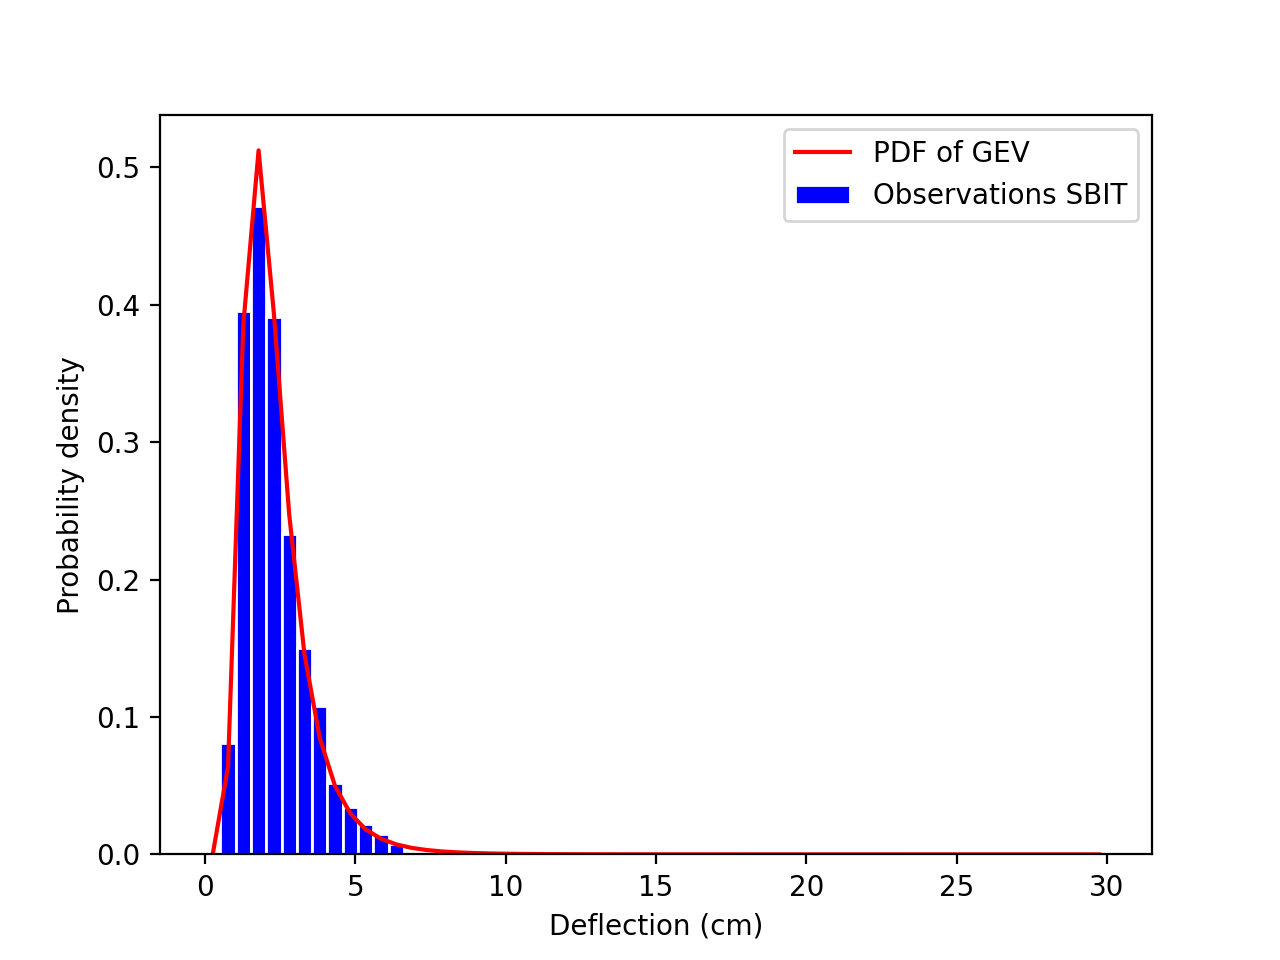

In [23]:
fig, ax1 = plt.subplots()

ax1.hist(data.peakDeflectionSBIT, bins=bins, label='Observations SBIT', color='blue', density= 'true', stacked='true', edgecolor='w')
ax1.plot(bin_centers, gev_pdf, label="PDF of GEV", color='r')
ax1.set_xlabel('Deflection (cm)')
ax1.set_ylabel('Probability density')

ax1.legend()

plt.show()

<IPython.core.display.Javascript object>


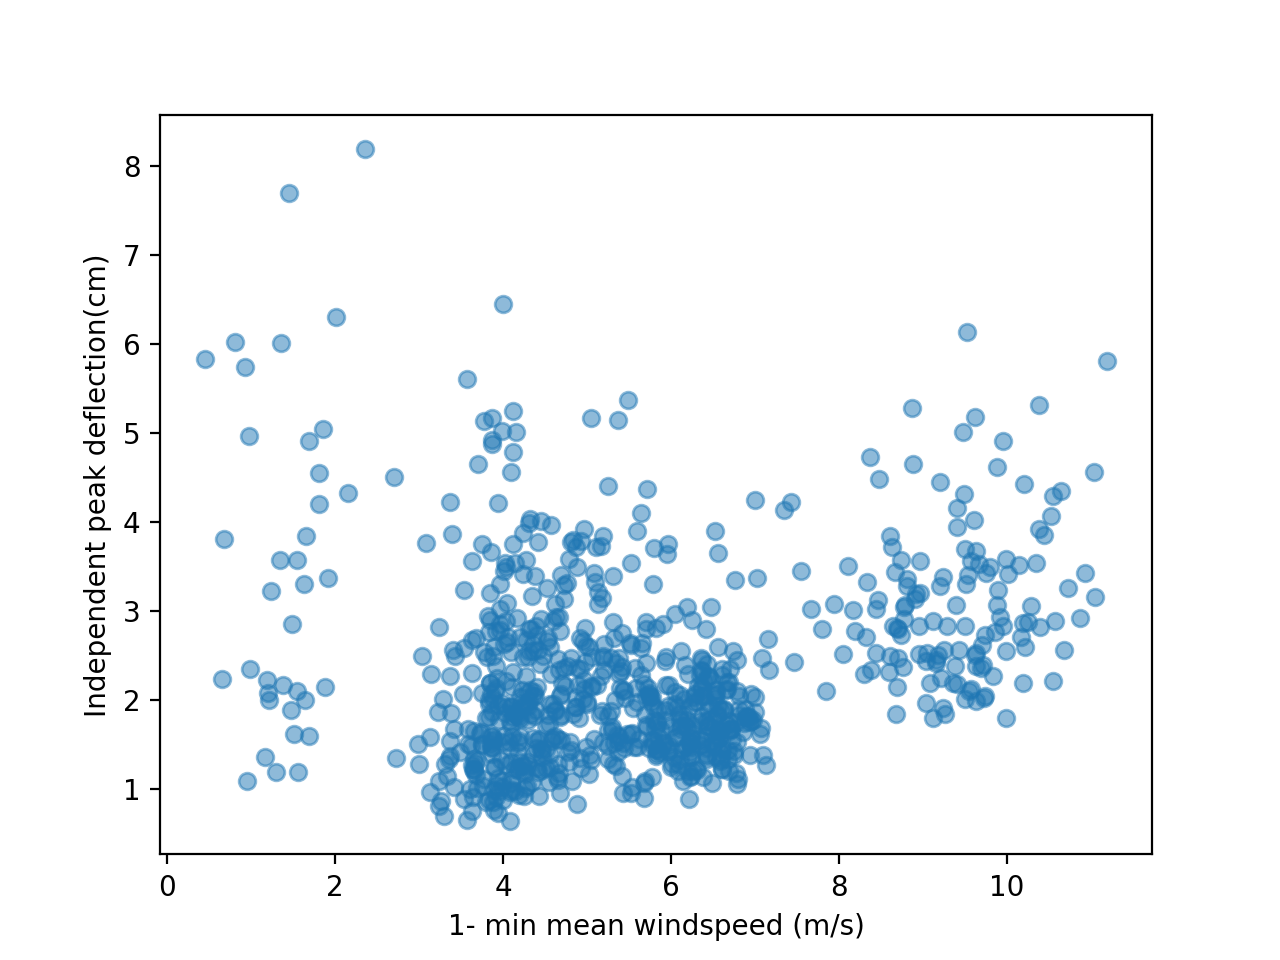

Text(0, 0.5, 'Independent peak deflection(cm)')

In [24]:
fig, ax1 = plt.subplots(1)
ax1.scatter(data.windSpeed, data.peakDeflectionSBIT, alpha= 0.5)
ax1.set_xlabel('1- min mean windspeed (m/s)')
ax1.set_ylabel('Independent peak deflection(cm)')

In [25]:
#r = np.corrcoef(data.windSpeed, data.waveHeight)
#print(r)
data.corr()

,windSpeed,waveHeight,waveTp,waveTz,peakDeflectionSBIT,peakDeflectionTower
windSpeed,1.000000,0.077811,-0.128155,-0.178240,0.147795,0.204713
waveHeight,0.077811,1.000000,0.826796,0.874009,0.246625,0.096135
waveTp,-0.128155,0.826796,1.000000,0.940959,0.130200,0.042690
waveTz,-0.178240,0.874009,0.940959,1.000000,0.227835,0.030987
peakDeflectionSBIT,0.147795,0.246625,0.130200,0.227835,1.000000,0.094591
peakDeflectionTower,0.204713,0.096135,0.042690,0.030987,0.094591,1.000000


## GEV Fit

<IPython.core.display.Javascript object>


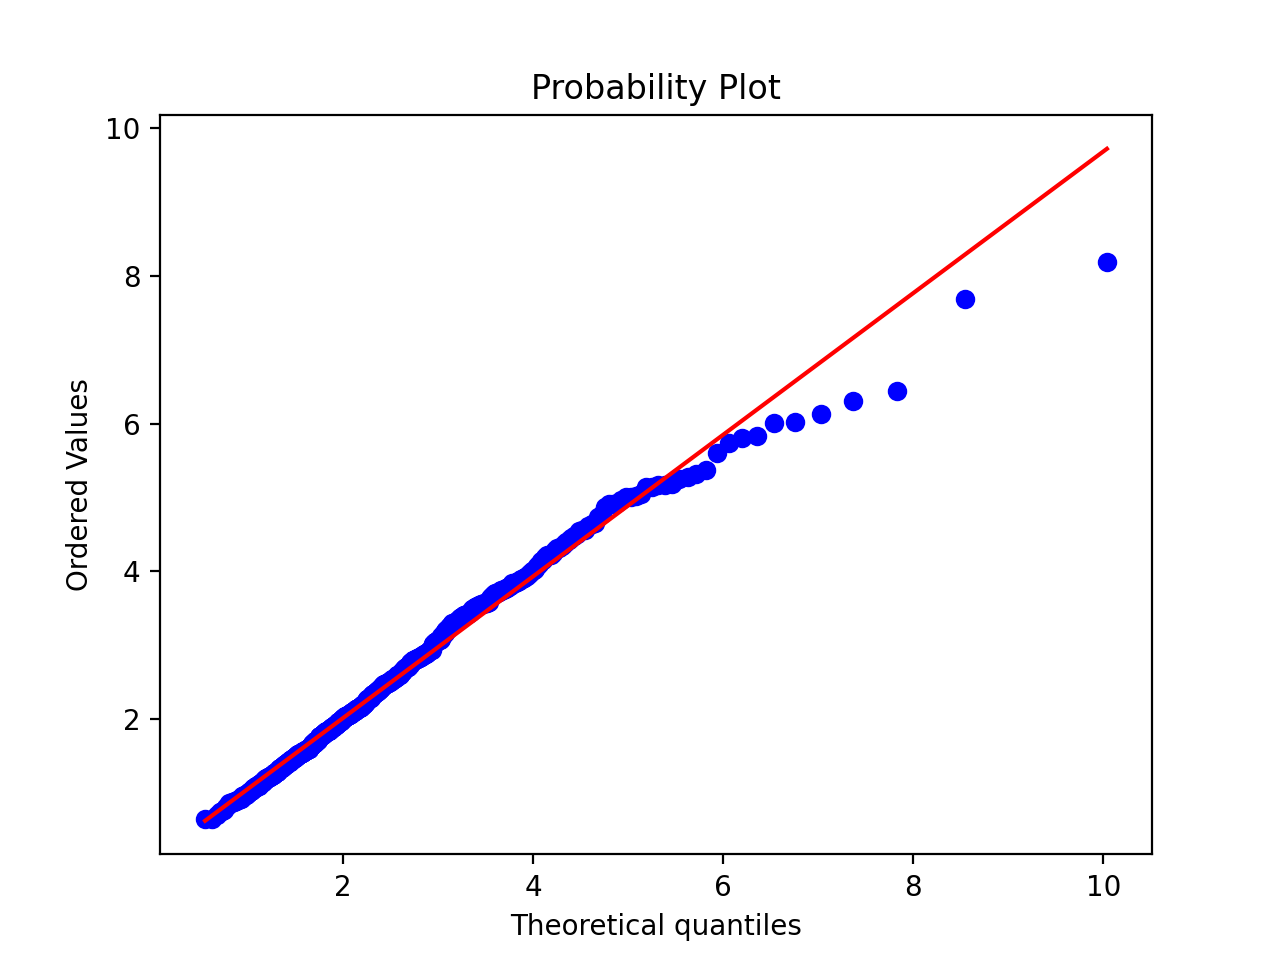

In [26]:
plt.figure()
stats.probplot(data.peakDeflectionSBIT, (gev_fit[0], gev_fit[1], gev_fit[2]), dist='genextreme', plot=pylab)
pylab.show()

In [27]:
#sm.qqplot(data.deflection, line ='45')
#plt.show()

In [28]:
#stats.kstest(data.deflection, gev_cdf, gev_fit)

In [29]:
#print(data.waveTz)

# Intervals

In [30]:
# Slice the data set of deflection into intervals of the wind speed.

width_slicer_V = WidthOfIntervalSlicer(width=1, reference="right", min_n_points=1)
wind_slices, wind_references, wind_boundaries = width_slicer_V.slice_(data.windSpeed)

deflection_intervals= []
for i in range (len(wind_references)):
    deflection_intervals.append([])


for i in range(len(wind_slices)):
    for j in range(len(wind_slices[i])):
        if (data.windSpeed[j] >= wind_boundaries[i][0]) & (data.windSpeed[j] < wind_boundaries[i][1]):
            deflection_intervals[i].append(data.peakDeflectionSBIT[j])


# Number of points per Interval
#for i in range(len(deflection_intervals)):
    #print(len(deflection_intervals[i]))

In [31]:
parameter_list= []
for i in range (len(gev_fit)):
    parameter_list.append([])

for i in range(len(deflection_intervals)):
    fit= stats.genextreme.fit(deflection_intervals[i])
    parameter_list[0].append(fit[0])
    parameter_list[1].append(fit[1])
    parameter_list[2].append(fit[2])

print(len(parameter_list[0]))

11


In [32]:
# shape parameter
mean= np.mean(parameter_list[0])
print(mean)

-0.11472415007115067


<IPython.core.display.Javascript object>


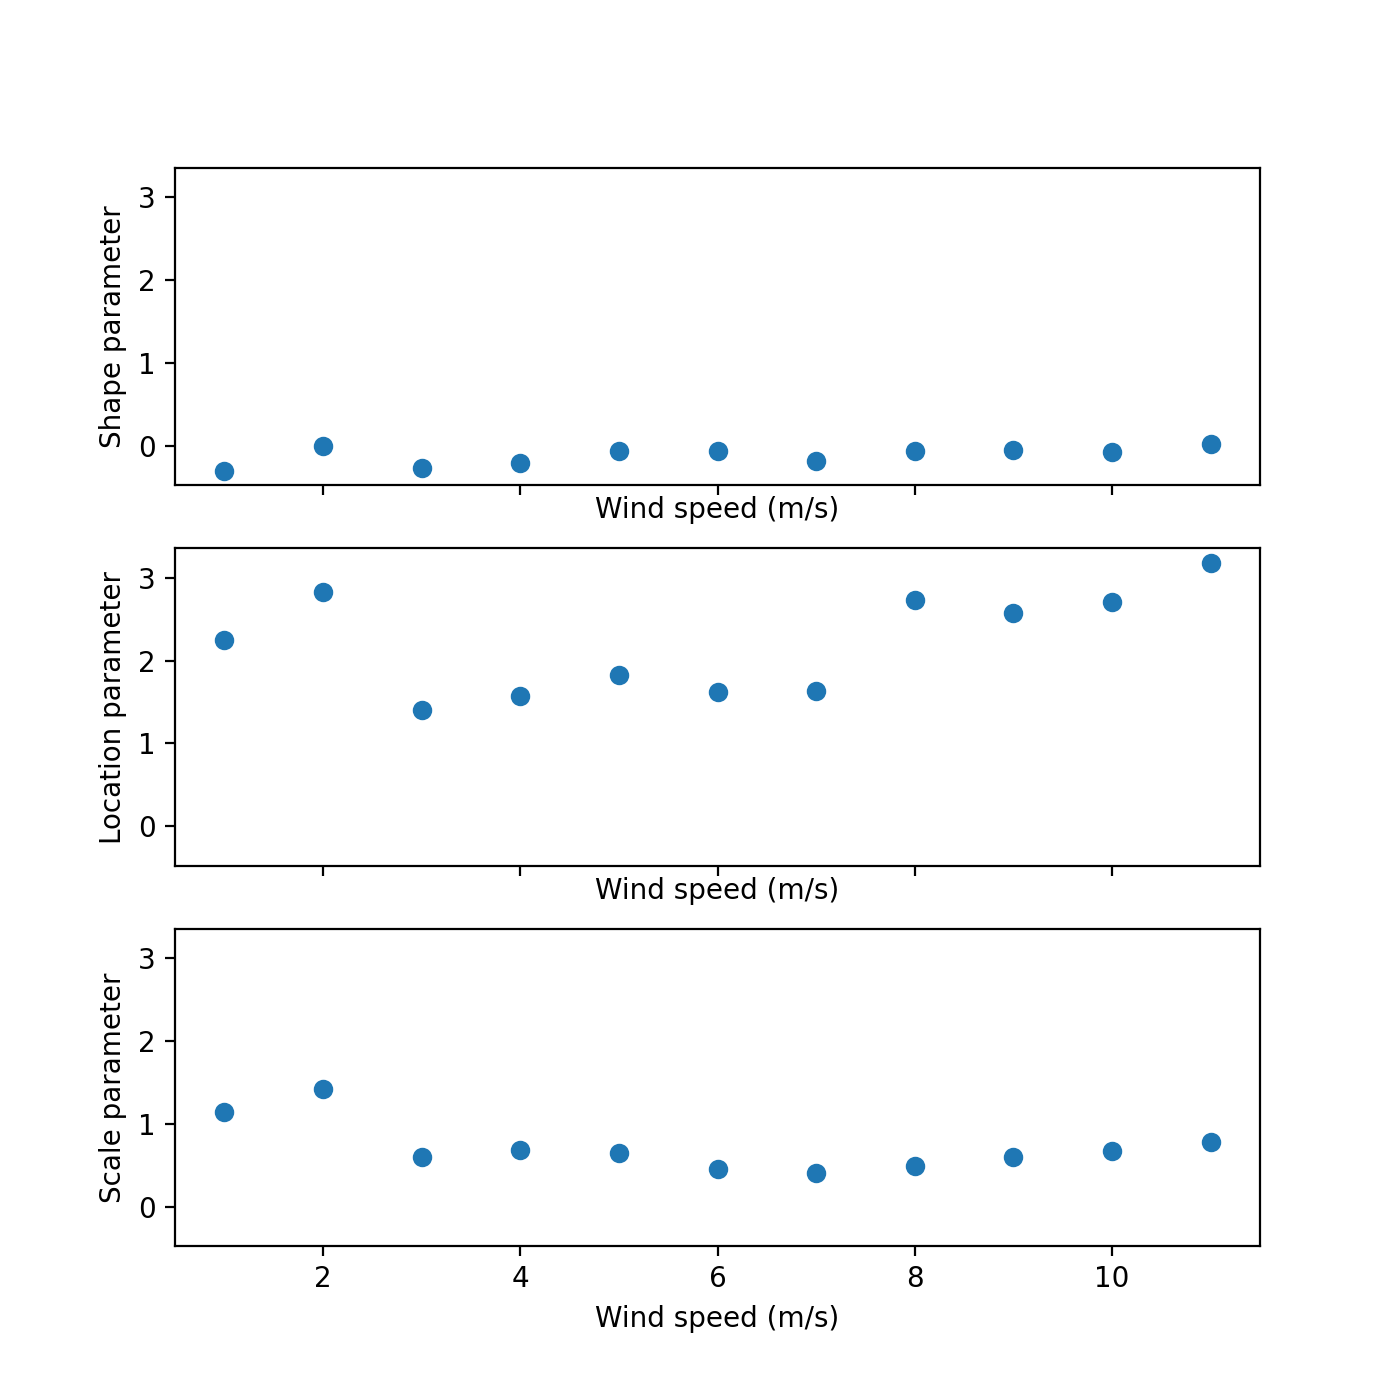

Text(0, 0.5, 'Scale parameter')

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex= True, figsize=(7,7))
ax1.scatter(wind_references, parameter_list[0])
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(wind_references, parameter_list[1])
ax2.set_xlabel('Wind speed (m/s)')
ax2.set_ylabel('Location parameter')
ax3.scatter(wind_references, parameter_list[2])
ax3.set_xlabel('Wind speed (m/s)')
ax3.set_ylabel('Scale parameter')

In [34]:
# WIND

r_shape_wind = np.corrcoef(parameter_list[0], wind_references)
r_location_wind = np.corrcoef(parameter_list[1], wind_references)
r_scale_wind = np.corrcoef(parameter_list[2], wind_references)
print(r_shape_wind)
print(r_location_wind)
print(r_scale_wind)

[[1.         0.59743541]
 [0.59743541 1.        ]]
[[1.         0.47638591]
 [0.47638591 1.        ]]
[[ 1.         -0.53373724]
 [-0.53373724  1.        ]]


# Dependence function of response

In [35]:
# Define dependence functions

def _power3(x, a, b, c):
    return a + b * x ** c
def _linear(x, a, b):
    return x * a + b
def _exp3(x, a, b, c):
    return a + b * np.exp(c * x)


bounds_3p = [(None, None), (None, None), (None, None)]
bounds_2p = [(None, None), (None, None)]
exp_bounds = [(0, None), (0, None), (None, None)]

power3 = DependenceFunction(_power3, bounds_3p, latex="$a + b * x^c$")
linear = DependenceFunction(_linear, latex="$a + b * x$")
exp3 = DependenceFunction(_exp3, bounds=exp_bounds)

#print(tuple(exp3.parameters.values()))
#print(tuple(linear.parameters.values()))
#print(tuple(power3.parameters.values()))

In [36]:
shape_param_fit= linear.fit(wind_references, parameter_list[0])
print(shape_param_fit)

#linear.fit(wind_references, parameter_list[0])
#print(linear)

None


In [37]:
x= np.asarray(wind_references)
y1= np.asarray(parameter_list[0]) #shape
y2= np.asarray(parameter_list[1]) #location
y3= np.asarray(parameter_list[2]) #scale

## linear fit

In [38]:
my_linear_param1 = fit_function(linear, x, y1, (1, 1), "lsq", None, None)
my_linear_param2 = fit_function(linear, x, y2, (1, 1), "lsq", None, None)
my_linear_param3 = fit_function(linear, x, y3, (1, 1), "lsq", None, None)
print(my_linear_param1)
print(my_linear_param2)
print(my_linear_param3)

[ 0.01917579 -0.2297789 ]
[0.08919855 1.67636924]
[-0.04915738  1.01615747]


<IPython.core.display.Javascript object>


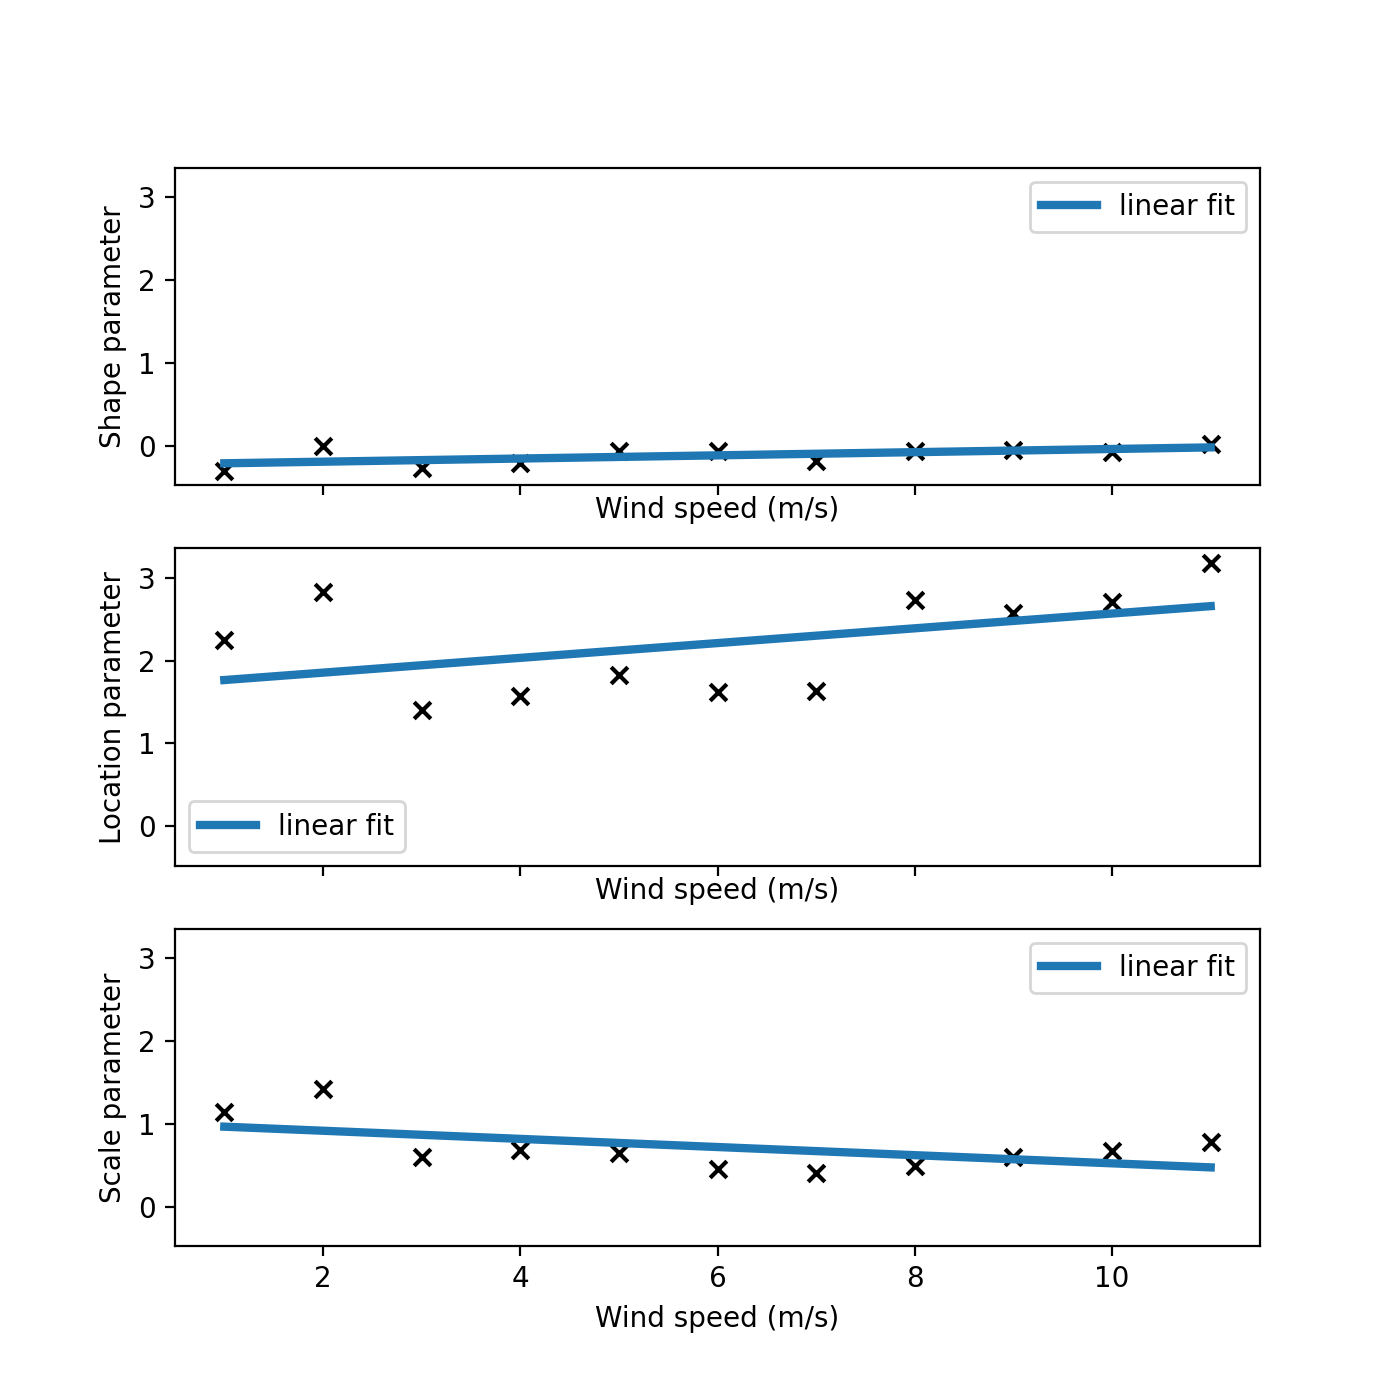

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex= True, figsize=(7,7))
ax1.scatter(x, y1, marker="x", c="k")
ax1.plot(x, linear(x, *my_linear_param1), label="linear fit", linewidth=3)
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(x, y2, marker="x", c="k")
ax2.plot(x, linear(x, *my_linear_param2), label="linear fit", linewidth=3)
ax2.set_xlabel('Wind speed (m/s)')
ax2.set_ylabel('Location parameter')
ax3.scatter(x, y3, marker="x", c="k")
ax3.plot(x, linear(x, *my_linear_param3), label="linear fit", linewidth=3)
ax3.set_xlabel('Wind speed (m/s)')
ax3.set_ylabel('Scale parameter')

ax1.legend()
ax2.legend()
ax3.legend()

In [40]:
#plt.figure()
#plt.scatter(x, y1, marker="x", c="k", label= 'shape parameter GEV')
#plt.plot(x, linear(x, *my_linear_param1), label="linear fit", linewidth=3)
#plt.xlabel('Wind speed (m/s)')
#plt.ylabel('Values of shape parameter GEV')
#plt.legend()

<IPython.core.display.Javascript object>


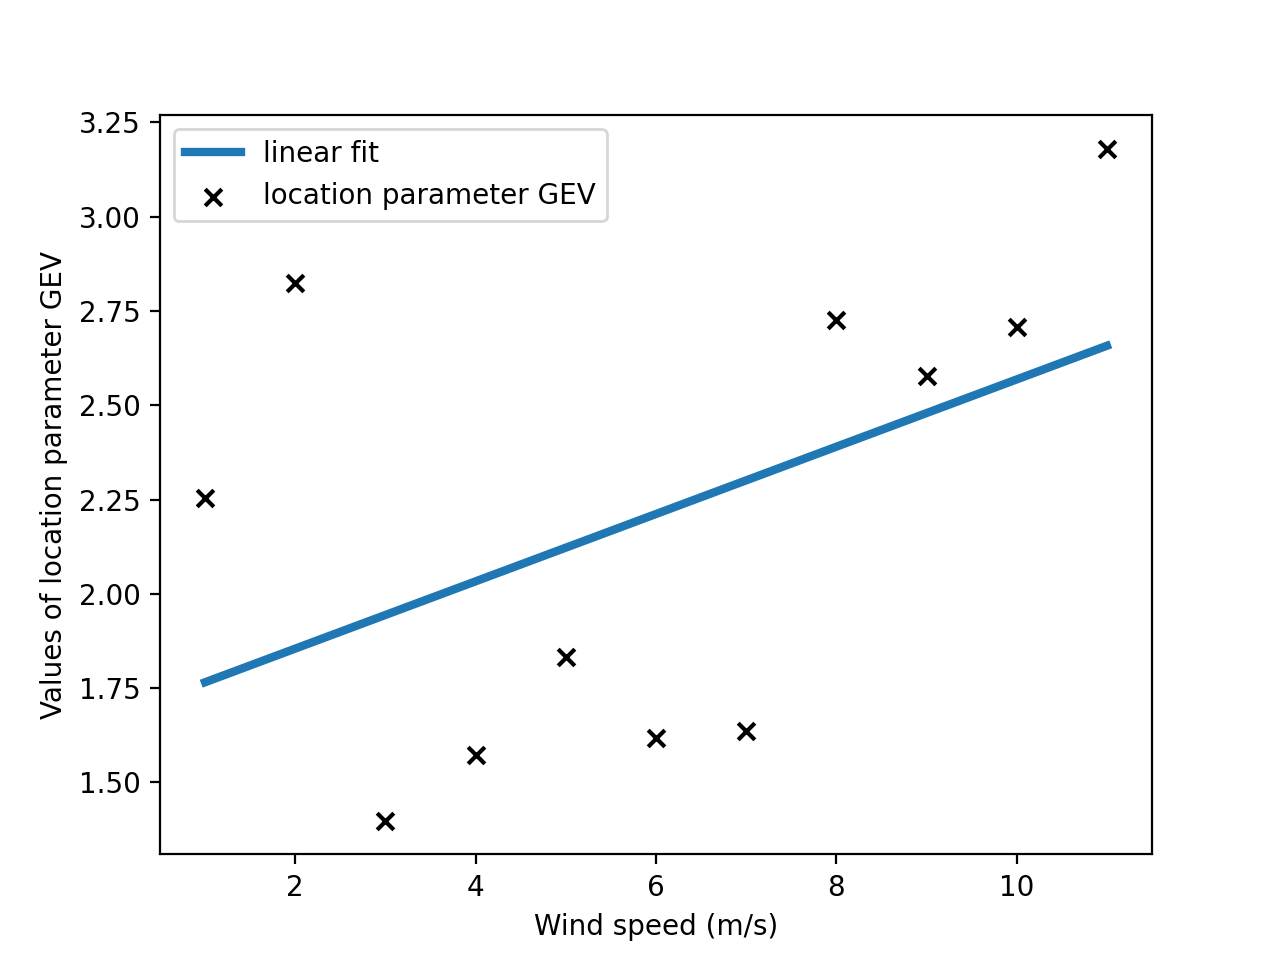

In [67]:
plt.figure()
plt.scatter(x, y2, marker="x", c="k", label= 'location parameter GEV')
plt.plot(x, linear(x, *my_linear_param2), label="linear fit", linewidth=3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Values of location parameter GEV')
plt.legend()

In [42]:
#plt.figure()
#plt.scatter(x, y3, marker="x", c="k", label= 'scale parameter GEV')
#plt.plot(x, linear(x, *my_linear_param3), label="linear fit", linewidth=3)
#plt.xlabel('Wind speed (m/s)')
#plt.ylabel('Values of scale parameter GEV')
#plt.legend()

# Alternative Dependency

In [49]:
#mean_absolute_error(data.deflection,)
#Korrelationskoeffizient
# Intervall von 0-2 anschauen, Maxima anschauen

# Mean deflection per interval
mean_deflection = []
for i in range(len(wind_references)):
    mean_deflection.append(np.mean(deflection_intervals[i]))

# Min deflection per interval
min_deflection = []
for i in range(len(wind_references)):
    min_deflection.append(min(deflection_intervals[i]))
    
# Max deflection per interval
max_deflection = []
for i in range(len(wind_references)):
    max_deflection.append(max(deflection_intervals[i]))
    
r_min = np.corrcoef(min_deflection, wind_references)
r_max = np.corrcoef(max_deflection, wind_references)
r_mean = np.corrcoef(mean_deflection, wind_references)
print(r_min)
print(r_mean)
print(r_max)

[[1.         0.76440649]
 [0.76440649 1.        ]]
[[1.         0.18594993]
 [0.18594993 1.        ]]
[[ 1.         -0.45415571]
 [-0.45415571  1.        ]]


In [50]:
my_linear_param_min = fit_function(linear, x, min_deflection, (1, 1), "lsq", None, None)
print(my_linear_param_min)

[0.13182091 0.50983818]


<IPython.core.display.Javascript object>


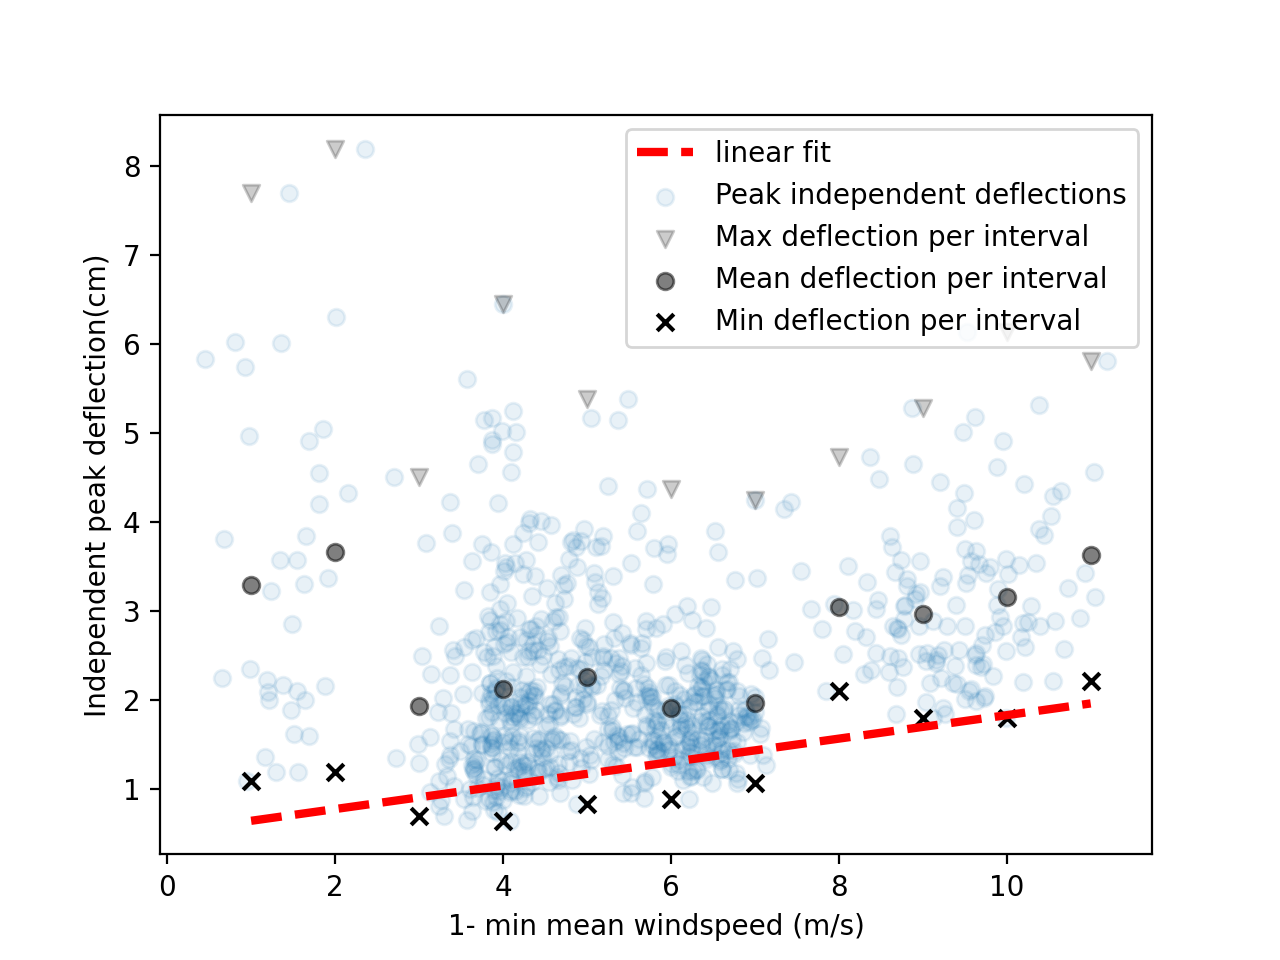

In [51]:
fig, ax1 = plt.subplots(1)
ax1.scatter(data.windSpeed, data.peakDeflectionSBIT, alpha= 0.1, label='Peak independent deflections')
ax1.scatter(wind_references, max_deflection, marker="v", c="k",alpha=0.2, label='Max deflection per interval')
ax1.scatter(wind_references, mean_deflection, marker="o", c="k",alpha=0.5, label='Mean deflection per interval')
ax1.scatter(wind_references, min_deflection, marker="x", c="k", label='Min deflection per interval')
ax1.plot(x, linear(x, *my_linear_param_min), linestyle='--', color= 'r',label="linear fit", linewidth=3)
ax1.set_xlabel('1- min mean windspeed (m/s)')
ax1.set_ylabel('Independent peak deflection(cm)')
ax1.legend()

# Modell 1: R

In [52]:
dist_R= stats.genextreme(gev_fit[0], gev_fit[1], gev_fit[2])
#cdf=joint_dist.cdf(r_grid)
#pdf=joint_dist.pdf(r_grid)
#rvs=joint_dist.rvs(size=(20,20))
rvs= dist_R.rvs(size=800)
#print(rvs)

In [53]:
peak_defl_SBIT= pd.DataFrame.to_numpy(data.peakDeflectionSBIT)
#print(peak_defl_SBIT)
model_error= peak_defl_SBIT-rvs
model_error= abs(model_error)

model_error_mean= np.nanmean(model_error)
print(model_error_mean)
print(min(data.peakDeflectionSBIT))
print(max(data.peakDeflectionSBIT))

1.1128248447510545
0.6434
8.1888


<IPython.core.display.Javascript object>


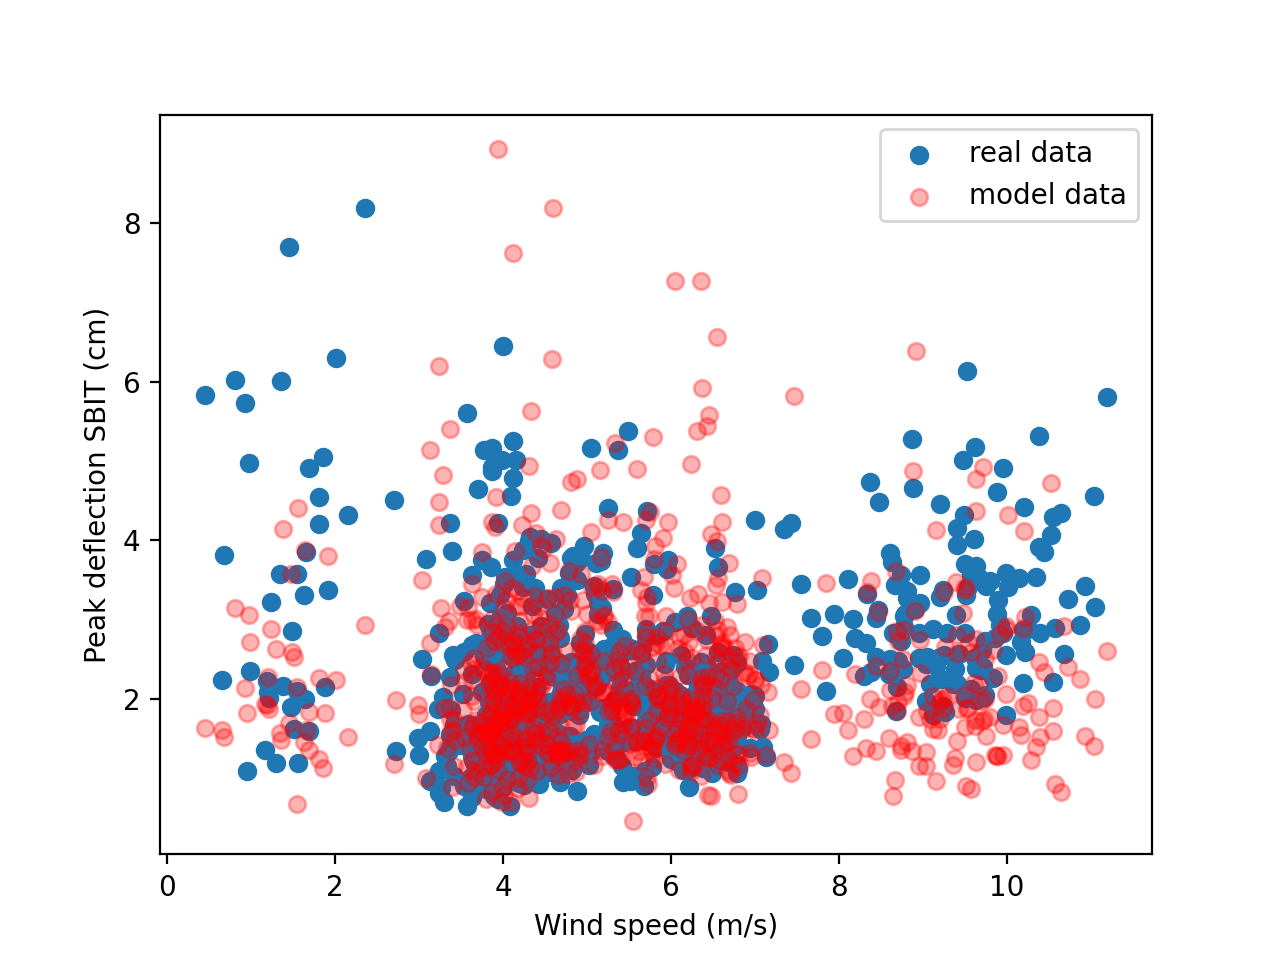

In [54]:
plt.figure()
plt.scatter(data.windSpeed, data.peakDeflectionSBIT, label='real data')
plt.scatter(data.windSpeed, rvs, alpha=0.3, color= 'r', label='model data')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Peak deflection SBIT (cm)')
plt.legend()

## Goodness of fit

In [55]:
print(np.quantile(data.peakDeflectionSBIT, 0.1))
print(np.quantile(rvs, 0.1))
print(data.peakDeflectionSBIT.median())
print(np.median(rvs))
print(np.quantile(data.peakDeflectionSBIT, 0.9))
print(np.quantile(rvs, 0.9))
print(np.quantile(data.peakDeflectionSBIT, 0.99))
print(np.quantile(rvs, 0.99))

1.21996
1.240648786674004
2.0564999999999998
1.9937442967316796
3.74867
3.4831332847521654
5.810962
6.193687467946264


# Modell 2: R(V)

In [56]:
def mu_func(v):
    return 0.089*v +1.676
def sigma_func(v):
    return -0.049*v +1.016

In [57]:
print(len(data))

800


In [58]:
mu= mu_func(data.windSpeed)
sigma= sigma_func(data.windSpeed)

In [59]:
con_dist_V= stats.genextreme(gev_fit[0], mu, gev_fit[2])
#cdf=joint_dist.cdf(r_grid)
#pdf=joint_dist.pdf(r_grid)
#rvs=joint_dist.rvs(size=(20,20))
rvs2D= con_dist_V.rvs(size=800)
#print(rvs)

In [60]:
peak_defl_SBIT= pd.DataFrame.to_numpy(data.peakDeflectionSBIT)
#print(peak_defl_SBIT)
model_error2D= peak_defl_SBIT-rvs2D
model_error2D= abs(model_error2D)

model_error2D_mean= np.nanmean(model_error2D)
print(model_error2D_mean)

1.1717522208010542


## Comparison real data and model

<IPython.core.display.Javascript object>


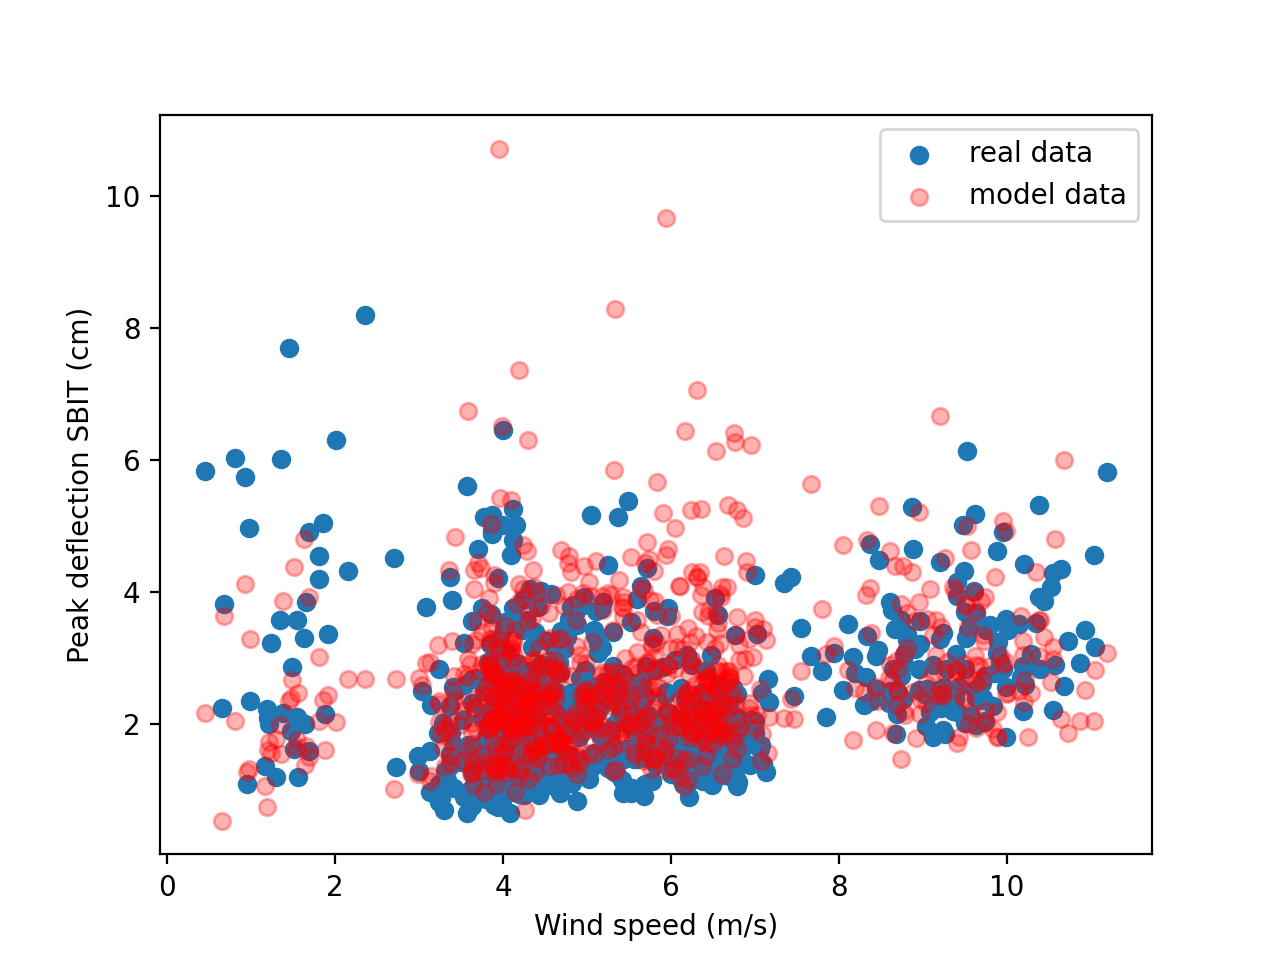

In [61]:
plt.figure()
plt.scatter(data.windSpeed, data.peakDeflectionSBIT, label='real data')
plt.scatter(data.windSpeed, rvs2D, alpha=0.3, color= 'r', label='model data')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Peak deflection SBIT (cm)')
plt.legend()

## Goodness of fit

In [62]:
print(np.quantile(data.peakDeflectionSBIT, 0.1))
print(np.quantile(rvs2D, 0.1))
print(data.peakDeflectionSBIT.median())
print(np.median(rvs2D))
print(np.quantile(data.peakDeflectionSBIT, 0.9))
print(np.quantile(rvs2D, 0.9))
print(np.quantile(data.peakDeflectionSBIT, 0.99))
print(np.quantile(rvs2D, 0.99))

1.21996
1.5409058074080613
2.0564999999999998
2.469669105648384
3.74867
4.091929520965124
5.810962
6.440778335982669


## Quantile Plots

In [63]:
intervals_V_1Dmodel= []
for i in range (len(wind_references)):
    intervals_V_1Dmodel.append([])


for i in range(len(wind_slices)):
    for j in range(len(wind_slices[i])):
        if (data.windSpeed[j] >= wind_boundaries[i][0]) & (data.windSpeed[j] < wind_boundaries[i][1]):
            intervals_V_1Dmodel[i].append(rvs[j])

intervals_V_2Dmodel= []
for i in range (len(wind_references)):
    intervals_V_2Dmodel.append([])
    
for i in range(len(wind_slices)):
    for j in range(len(wind_slices[i])):
        if (data.windSpeed[j] >= wind_boundaries[i][0]) & (data.windSpeed[j] < wind_boundaries[i][1]):
            intervals_V_2Dmodel[i].append(rvs2D[j])

In [64]:
# discrete quantiles 

quantile10_data= []
quantile50_data= []
quantile90_data= []
quantile99_data= []

quantile10_model1D= []
quantile50_model1D= []
quantile90_model1D= []
quantile99_model1D= []

quantile10_model2D= []
quantile50_model2D= []
quantile90_model2D= []
quantile99_model2D= []

for i in range (len(deflection_intervals)):
    quantile10_data.append(np.quantile(deflection_intervals[i], 0.10))
    quantile50_data.append(np.quantile(deflection_intervals[i], 0.50))
    quantile90_data.append(np.quantile(deflection_intervals[i], 0.90))
    quantile99_data.append(np.quantile(deflection_intervals[i], 0.99))
    
for i in range (len(intervals_V_1Dmodel)):
    quantile10_model1D.append(np.quantile(intervals_V_1Dmodel[i], 0.10))
    quantile50_model1D.append(np.quantile(intervals_V_1Dmodel[i], 0.50))
    quantile90_model1D.append(np.quantile(intervals_V_1Dmodel[i], 0.90))
    quantile99_model1D.append(np.quantile(intervals_V_1Dmodel[i], 0.99))
    
for i in range (len(intervals_V_2Dmodel)):
    quantile10_model2D.append(np.quantile(intervals_V_2Dmodel[i], 0.10))
    quantile50_model2D.append(np.quantile(intervals_V_2Dmodel[i], 0.50))
    quantile90_model2D.append(np.quantile(intervals_V_2Dmodel[i], 0.90))
    quantile99_model2D.append(np.quantile(intervals_V_2Dmodel[i], 0.99))

In [65]:
# 2D quantiles continuous
quantiles2D_10= con_dist_V.ppf(0.1)
quantiles2D_50= con_dist_V.ppf(0.5)
quantiles2D_90= con_dist_V.ppf(0.9)

# 1D quantiles continuous
quantiles1D_10= dist_R.ppf(0.1)
quantiles1D_50= dist_R.ppf(0.5)
quantiles1D_90= dist_R.ppf(0.9)
print(quantiles1D_10)

1.2240468361595602


<IPython.core.display.Javascript object>


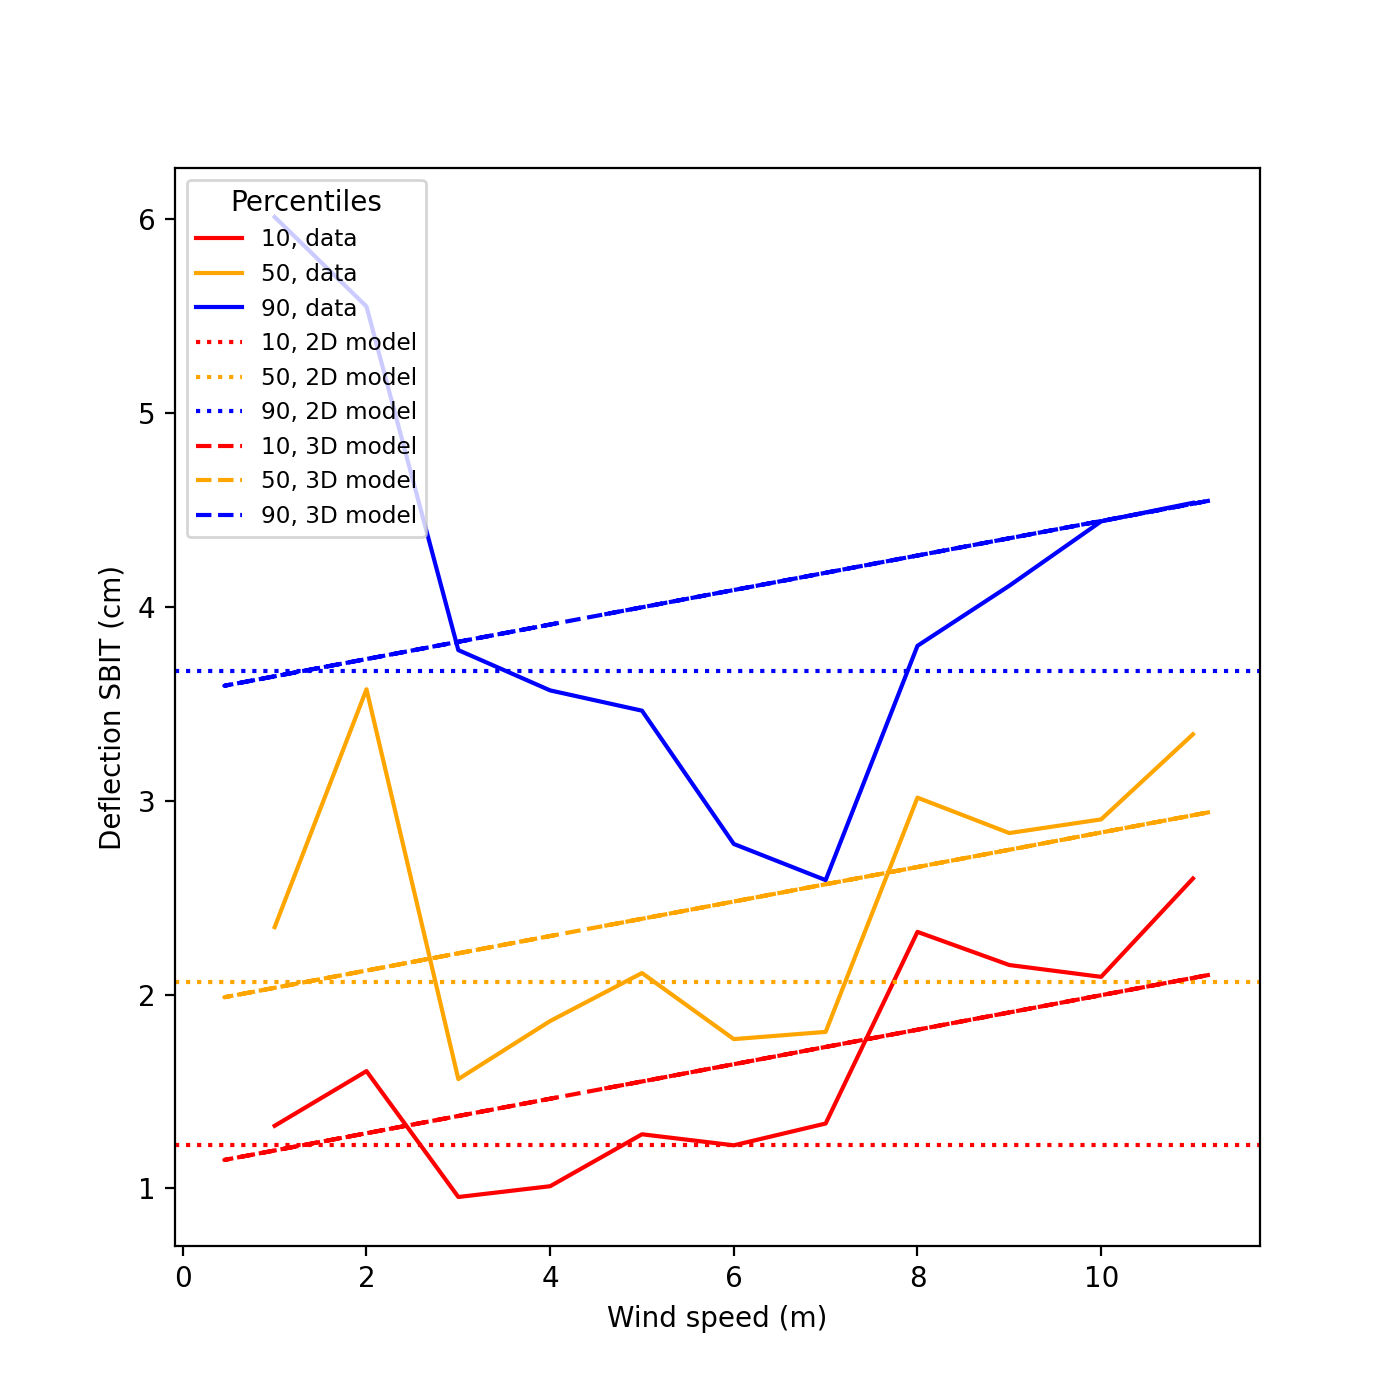

In [66]:
plt.figure(figsize=(7,7))
#plt.scatter(data.waveHeight, data.peakDeflectionTower, color= 'k', alpha= 0.3)
plt.plot(wind_references, quantile10_data, color='r', label='10, data')
plt.plot(wind_references, quantile50_data, color='orange', label='50, data')
plt.plot(wind_references, quantile90_data, color='b', label='90, data')
#plt.plot(waveH_references, quantile99_data, color='green', label='99, data')

plt.axhline(y=quantiles1D_10, color='r', linestyle=':',  label='10, 2D model')
plt.axhline(y=quantiles1D_50, color='orange', linestyle=':',  label='50, 2D model')
plt.axhline(y=quantiles1D_90, color='b', linestyle=':',  label='90, 2D model')

plt.plot(data.windSpeed, quantiles2D_10, color='r', label='10, 3D model', linestyle='--')
plt.plot(data.windSpeed, quantiles2D_50, color='orange', label='50, 3D model', linestyle='--')
plt.plot(data.windSpeed, quantiles2D_90, color='b', label='90, 3D model', linestyle='--')

#plt.plot(wind_references, quantile10_model1D, color='r', linestyle=':', label='10, 2D model')
#plt.plot(wind_references, quantile50_model1D, color='orange', linestyle=':', label='50, 2D model')
#plt.plot(wind_references, quantile90_model1D, color='b', linestyle=':', label='90, 2D model')
#plt.plot(waveH_references, quantile99_model2D, color='green', linestyle=':', label='99, 2D model')

#plt.plot(wind_references, quantile10_model2D, color='r', label='10, 3D model', linestyle='--')
#plt.plot(wind_references, quantile50_model2D, color='orange', label='50, 3D model', linestyle='--')
#plt.plot(wind_references, quantile90_model2D, color='b', label='90, 3D model', linestyle='--')
#plt.plot(waveH_references, quantile99_model3D, color='green', label='99, 3D model', linestyle='--')

plt.xlabel('Wind speed (m)')
plt.ylabel('Deflection SBIT (cm)')
plt.legend(title='Percentiles', loc=2, fontsize='small', fancybox=True)